## Imports

In [2]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping

import torch
import torch.nn as nn

import numpy as np

import os

from TurbulenceNetwork import TurbulenceNetwork
from TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Misc Utilities

In [3]:
class MAPELoss:
    def __init__(self, *args, **kwargs):
        self.eta = 1e-5
        pass

    def __call__(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true)) * 100

        return torch.mean(l)


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/TurbulenceClosureDataGenerator.py:85: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)*np.sqrt(-a**3/27))


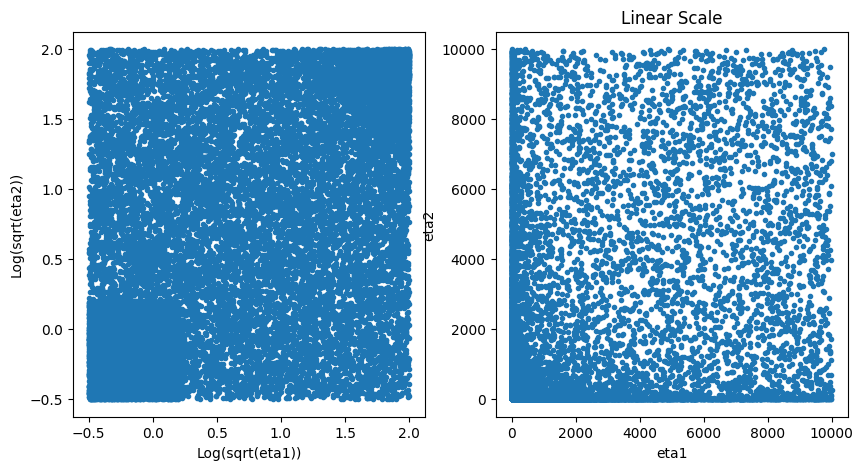

In [23]:
LLR_gen = TurbulenceClosureDataGenerator('LRR')
SSG_gen = TurbulenceClosureDataGenerator('SSG')
SZL_gen = TurbulenceClosureDataGenerator('SZL')

log_narrow = (-.5, .2)
log = (-.5, 2)
lin = (.1, 10_000)

# Generating data on a narrowed log scale
LLR_x_log_narrow, LLR_y_log_narrow = LLR_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)
SSG_x_log_narrow, SSG_y_log_narrow = SSG_gen((10**np.random.uniform(*log_narrow, 10_000))**2, (10**np.random.uniform(*log_narrow, 10_000))**2)
SZL_x_log_narrow, SZL_y_log_narrow = SZL_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)

# Generating data on a log scale
LLR_x_log, LLR_y_log = LLR_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)
SSG_x_log, SSG_y_log = SSG_gen((10**np.random.uniform(*log, 14_000))**2, (10**np.random.uniform(*log, 14_000))**2)
SZL_x_log, SZL_y_log = SZL_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)

# Generating data on a linear scale
LLR_x_lin, LLR_y_lin = LLR_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))
SSG_x_lin, SSG_y_lin = SSG_gen(np.random.uniform(*lin, 3_000), np.random.uniform(*lin, 3_000))
SZL_x_lin, SZL_y_lin = SZL_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))

x = np.concatenate((
    LLR_x_log_narrow, SSG_x_log_narrow, SZL_x_log_narrow,
    LLR_x_log, SSG_x_log, SZL_x_log,
    SSG_x_lin, LLR_x_lin, SZL_x_lin
    ))
y = np.concatenate((
    LLR_y_log_narrow, SSG_y_log_narrow, SZL_y_log_narrow,
    LLR_y_log, SSG_y_log, SZL_y_log,
    SSG_y_lin, LLR_y_lin, SZL_y_lin
    ))
y = y + np.random.normal(0, .1, y.shape)

plot_data_generation_diff(np.log10(np.sqrt(x)))

total = np.concatenate((x, y), axis=1)

np.random.shuffle(total)

etas_train = total[:, :2]
gs_train = total[:, 2:]

x_test_LLR , y_test_LLR = LLR_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))
x_test_SSG , y_test_SSG = SSG_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))
x_test_SZL , y_test_SZL = SZL_gen(np.random.uniform(.1, 10_000, 1_000), np.random.uniform(.1, 10_000, 1_000))

etas_test = np.concatenate((x_test_LLR, x_test_SSG, x_test_SZL))
gs_test = np.concatenate((y_test_LLR, y_test_SSG, y_test_SZL))


## Network Training

In [24]:
model = TurbulenceNetwork(input_dim=2, output_dim=3, num_layers=7, nodes=[7, 7, 7, 7, 7, 7, 7], dropout=0.01)
criterion = nn.L1Loss
optimizer = torch.optim.Adam


In [25]:
callbacks = [EarlyStopping(patience=20, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
            Checkpoint(monitor='valid_loss_best', f_params='TurbulenceNetwork.pt', dirname='./Model_Checkpoints/')
]

net = NeuralNetRegressor(   
        module=model,
        criterion=criterion,
        optimizer=optimizer,
        optimizer__weight_decay=0.00001,
        lr=0.0001,
        batch_size=64,
        max_epochs=400,
        device=device,
        iterator_train__shuffle=True,
        iterator_train__num_workers=4,
        iterator_train__pin_memory=True,
        iterator_valid__shuffle=False,
        iterator_valid__num_workers=4,
        iterator_valid__pin_memory=True,
        callbacks=callbacks,
)

net = net.fit(etas_train, gs_train)



  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.3069        0.2293     +  0.6582
      2        0.2081        0.1802     +  0.6983
      3        0.1625        0.1409     +  0.6624
      4        0.1342        0.1240     +  0.6080
      5        0.1242        0.1177     +  0.6250
      6        0.1201        0.1167     +  0.6304
      7        0.1176        0.1144     +  0.6361
      8        0.1160        0.1134     +  0.6586
      9        0.1145        0.1114     +  0.6215
     10        0.1126        0.1097     +  0.6394
     11        0.1112        0.1083     +  0.6418
     12        0.1096        0.1071     +  0.6611
     13        0.1078        0.1049     +  0.6349
     14        0.1066        0.1039     +  0.6486
     15        0.1052        0.1025     +  0.6547
     16        0.1046        0.1013     +  0.6819
     17        0.1029        0.0997     +  0.6769
     18        0.1012        0.0982     +  0.6541


## Reinitializing Trained Model

In [26]:
checkpoint_dir = './Model_Checkpoints'

net = NeuralNetRegressor(
    module=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

net.initialize()
net.load_params(f_params=os.path.join(checkpoint_dir,'TurbulenceNetwork.pt'),
                f_optimizer=os.path.join(checkpoint_dir, 'optimizer.pt'),
                f_criterion=os.path.join(checkpoint_dir, 'criterion.pt'),
                f_history=os.path.join(checkpoint_dir, 'history.json')
)

## Generating Statistics Data

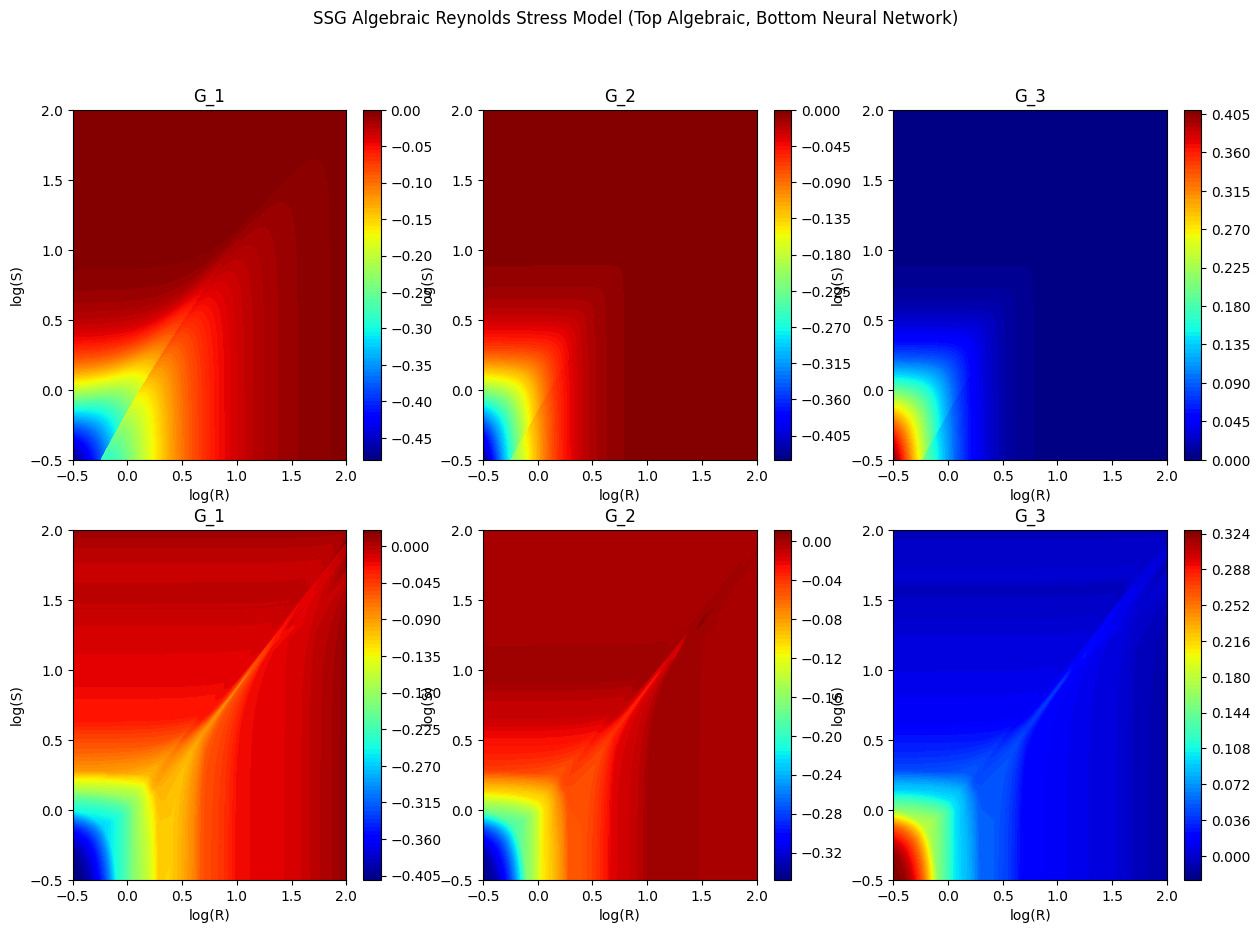

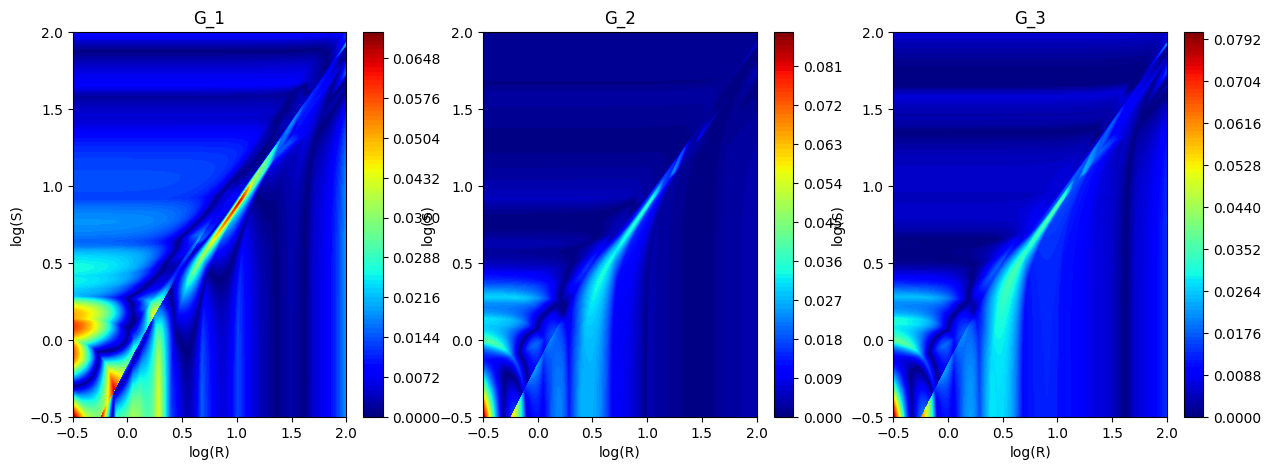

In [27]:
dim = 800
x_grid, y_grid = np.meshgrid(np.linspace(-.5, 2, dim),np.linspace(-.5, 2, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

pred = net.predict(etas)

pred = pred.T.reshape(3, dim, dim)

plot_heat_map_compare(x_grid, y_grid, target, pred)

plot_heat_map_loss(x_grid, y_grid, target, pred)

del pred

## Generating Model Uncertainty From Dropout

In [28]:
T = 300
predictions = np.zeros((T, dim*dim, 3))

net.module.dropout_on(.01)

for i in range(T):
    pred = net.module(torch.tensor(etas).to(device)).cpu().detach()
    predictions[i] = pred


print(predictions.shape)


(300, 640000, 3)


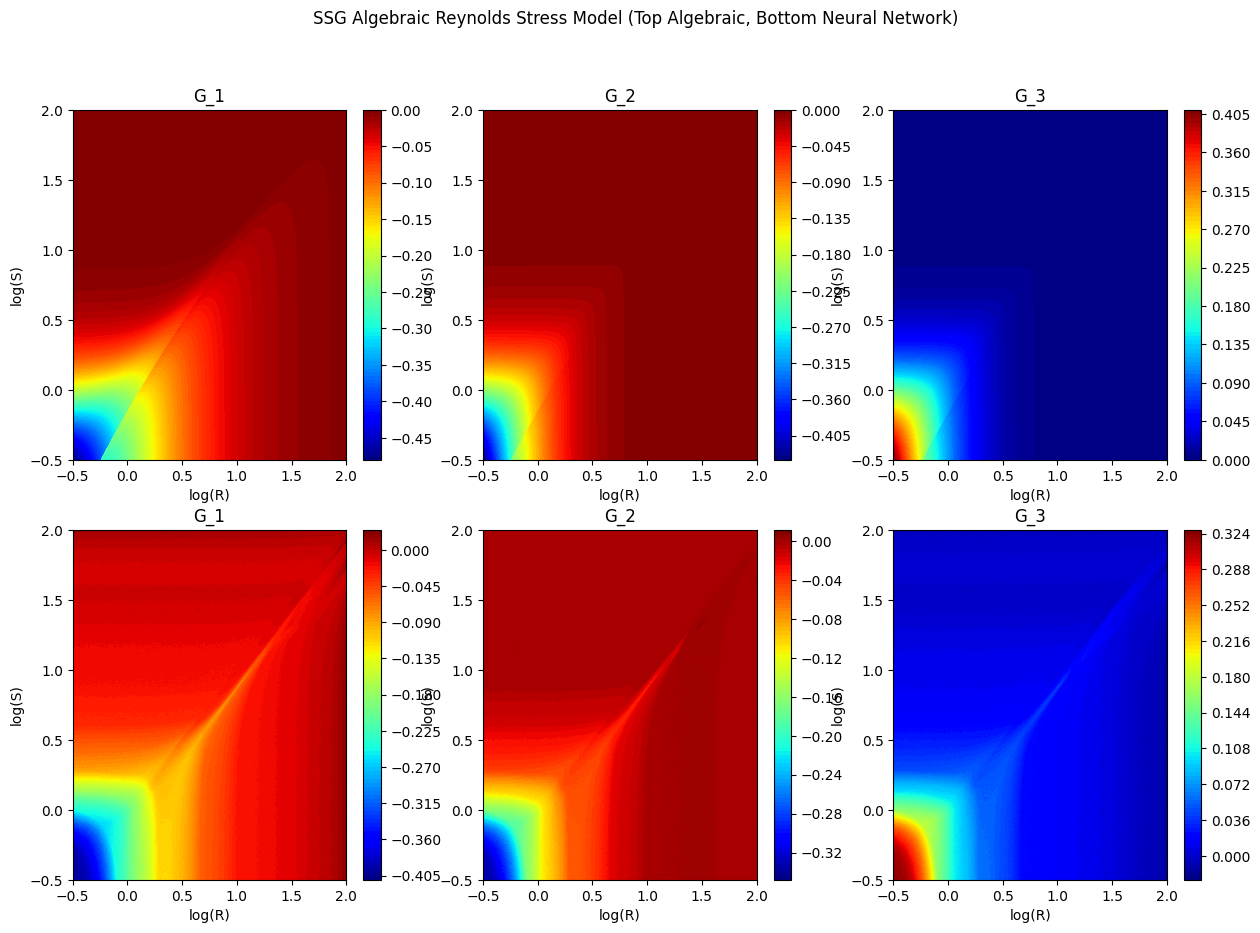

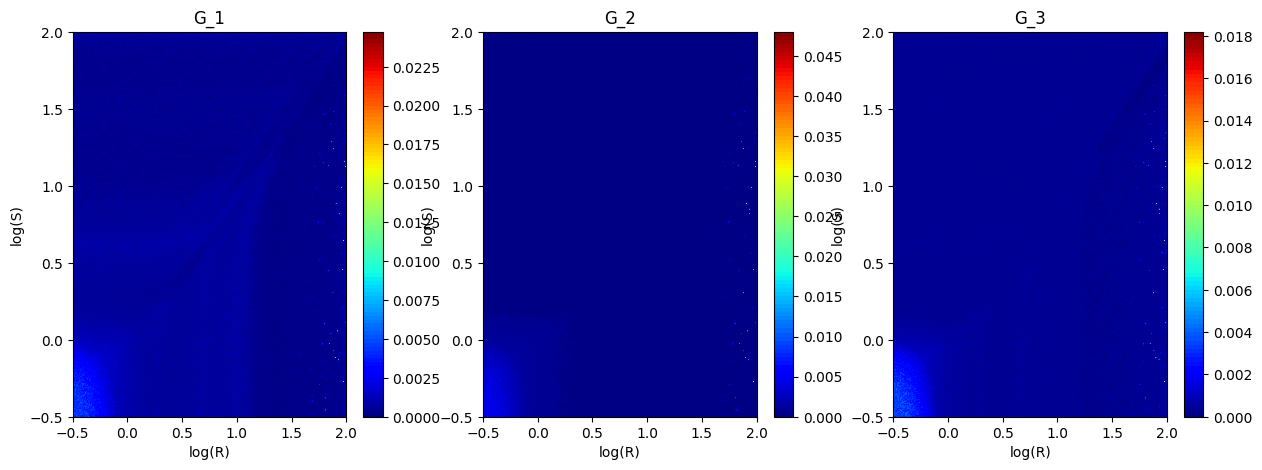

In [29]:
mean_pred = np.mean(predictions, axis=0)

variance_pred = np.mean((predictions - mean_pred)**2, axis=0)

del predictions

plot_heat_map_compare(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim))

plot_heat_map_loss(x_grid, y_grid, 0.0, variance_pred.T.reshape(3, dim, dim))
